In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
from tqdm import tqdm

import matplotlib.pyplot as plt

c:\Users\Aaron\Anaconda3\envs\deepLearningCuda11-OpenAI\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


In [3]:
from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms

class CropDiseaseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = os.listdir(root_dir)
        self.class_to_idx = {cls: idx for idx, cls in enumerate(self.classes)}
        self.idx_to_class = {idx: cls for idx, cls in enumerate(self.classes)}

        # Initialize the list to store image paths and labels
        self.samples = []

        # Iterate through each class folder
        for cls in self.classes:
            class_path = os.path.join(root_dir, cls)
            if os.path.isdir(class_path):
                for img in os.listdir(class_path):
                    path = os.path.join(class_path, img).replace('\\\\', '/').replace('\\', '/')
                    path = os.path.normpath(path)
                    if os.path.exists(path):
                        self.samples.extend([(path, cls)])
                

    def __len__(self):
        return len(self.samples)
    
    def displayImage(self, idx):
        img_path, folder_name = self.samples[idx]
        img = Image.open(img_path).convert("RGB")
        display(img)
        # plt.imshow(img)
        # plt.axis('off')
        # plt.show()

    
    def getItemVerbose(self, idx, displayImage=False):
        if displayImage:
            self.displayImage(idx)
            
        img, label_idx = self[idx]
        img_path, label = self.samples[idx]
        return img_path, label_idx, label


    def __getitem__(self, idx):
        img_path, folder_name = self.samples[idx]

        # Open the image using PIL
        img = Image.open(img_path).convert("RGB")

        # Apply transformations if provided
        if self.transform:
            img = self.transform(img)

        class_idx = self.class_to_idx[folder_name]
        one_hot_label = torch.nn.functional.one_hot(torch.tensor(class_idx), num_classes=len(self.classes))

        return img, class_idx

In [4]:
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Resize((224, 224), antialias=True),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to [0, 1]
        ])


source_path_train = 'D:/Rutgers/ExtraProjects/HackPrinceton23/HackPrinceton23/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/train'
source_path_valid = 'D:/Rutgers/ExtraProjects/HackPrinceton23/HackPrinceton23/New Plant Diseases Dataset(Augmented)/New Plant Diseases Dataset(Augmented)/valid'

# Replace 'path/to/your/dataset' with the actual path to your dataset
train_dataset = CropDiseaseDataset(root_dir=source_path_train, transform=transform)
valid_dataset = CropDiseaseDataset(root_dir=source_path_valid, transform=transform)

print("Train Dataset Total Size: ", len(train_dataset))
print("Validation Dataset Total Size: ", len(valid_dataset))


Train Dataset Total Size:  69877
Validation Dataset Total Size:  17477


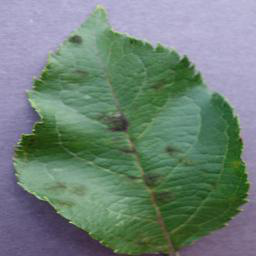

Sample Image Path:  D:\Rutgers\ExtraProjects\HackPrinceton23\HackPrinceton23\New Plant Diseases Dataset(Augmented)\New Plant Diseases Dataset(Augmented)\train\Apple___Apple_scab\00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG
Sample Label:  Apple___Apple_scab
Sample One Hot:  0


In [5]:
# Visualize a sample from the training dataset

img_path, one_hot_label, label = train_dataset.getItemVerbose(0, displayImage=True)
print("Sample Image Path: ", img_path)
print("Sample Label: ", label)
print("Sample One Hot: ", one_hot_label)

## Now, let's build a classification model by fine-tuning ResNet

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if not torch.cuda.is_available(): print("WARNING: Model will run extremely slow on cpu")

In [7]:
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights

class ResNetClassifer(nn.Module):
    def __init__(self, num_classes):
        super(ResNetClassifer, self).__init__()
        self.num_classes = num_classes

        # Use a pre-trained ResNet model from Hugging Face
        self.resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)

        for param in self.resnet_model.parameters():
            param.requires_grad = False

        # Add a global average pooling layer
        self.global_avg_pooling = nn.AdaptiveAvgPool2d(1)

        # Fully connected layers for embedding
        fc_inputs = self.resnet_model.fc.in_features
        self.resnet_model.fc = nn.Sequential(
            nn.Linear(fc_inputs, 256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, num_classes), 
            nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        return self.resnet_model(x)

In [8]:
def accuracy(predictions, labels):
    # Convert the predictions to class indices
    _, predicted_classes = predictions.max(1)

    # Calculate accuracy
    correct_predictions = (predicted_classes == labels).sum().item()
    total_samples = labels.size(0)
    acc = correct_predictions / total_samples
    
    return acc

In [9]:
# Hyperparamters
batch_size = 64
num_classes = 38
learning_rate = 1e-4
num_epochs = 3


In [10]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

ClassifierModel = ResNetClassifer(num_classes).to(device)

In [12]:
optimizer = optim.Adam(ClassifierModel.parameters(), lr=learning_rate)

# Define cross entropy loss
criterion = nn.NLLLoss()
loss_list = []
val_loss_list = []
train_accuracy_list = []
val_accuracy_list = []


# Training Loop
num_epochs = 5
for epoch in range(num_epochs):
    
    # Create a tqdm progress bar for the training loader
    train_loader_iter = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)
    for batch in train_loader_iter:
        x, y = [th.to(device) for th in batch]
        x = ClassifierModel(x)
        loss = criterion(x, y)
        acc = accuracy(x, y)
        train_accuracy_list.append(acc)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        train_loader_iter.set_postfix({'Loss': loss.item(), 'Acc': acc})

    # Validation loop
    with torch.no_grad():
        total_validation_loss = 0.0
        num_batches = 0
        for batch in validation_loader:
            x, y = [th.to(device) for th in batch]
            optimizer.zero_grad()
            x = ClassifierModel(x)
            validation_loss = criterion(x, y)
            val_acc = accuracy(x, y)
            val_accuracy_list.append(val_acc)
            total_validation_loss += validation_loss.item()
            num_batches += 1
        average_validation_loss = total_validation_loss / num_batches

    epoch_train_accuracy = torch.tensor(train_accuracy_list).mean().item()
    epoch_val_accuracy = torch.tensor(val_accuracy_list).mean().item()
    train_accuracy_list = []
    val_accuracy_list = []
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}, Accuracy: {epoch_train_accuracy}, Validation Loss: {average_validation_loss}, Val. Accuracy: {epoch_val_accuracy}')
    loss_list.append(loss.item())
    val_loss_list.append(average_validation_loss)

Epoch 1/5: 100%|██████████| 1092/1092 [38:53<00:00,  2.14s/it, Loss=0.574, Acc=0.849]


Epoch [1/5], Loss: 0.5740472078323364, Accuracy: 0.703344464302063, Validation Loss: 0.6863555937570377, Val. Accuracy: 0.8470233082771301


Epoch 2/5: 100%|██████████| 1092/1092 [03:28<00:00,  5.24it/s, Loss=0.364, Acc=0.887]


Epoch [2/5], Loss: 0.36442831158638, Accuracy: 0.8811920881271362, Validation Loss: 0.4025566310343081, Val. Accuracy: 0.8990077376365662


Epoch 3/5: 100%|██████████| 1092/1092 [03:29<00:00,  5.21it/s, Loss=0.214, Acc=0.962]


Epoch [3/5], Loss: 0.21394895017147064, Accuracy: 0.9162601232528687, Validation Loss: 0.2977637135199387, Val. Accuracy: 0.9189324975013733


Epoch 4/5: 100%|██████████| 1092/1092 [03:29<00:00,  5.21it/s, Loss=0.4, Acc=0.868]  


Epoch [4/5], Loss: 0.3998115062713623, Accuracy: 0.9341882467269897, Validation Loss: 0.24456362997310876, Val. Accuracy: 0.9327782988548279


Epoch 5/5: 100%|██████████| 1092/1092 [03:28<00:00,  5.23it/s, Loss=0.202, Acc=0.925] 


Epoch [5/5], Loss: 0.20216168463230133, Accuracy: 0.9448857307434082, Validation Loss: 0.20767842636980716, Val. Accuracy: 0.940579354763031


In [14]:
# Save model for later use
torch.save(ClassifierModel.state_dict(), 'DiseasedCropClassifier_5epochs_secondIteration.pth')

## Visualize the Learning

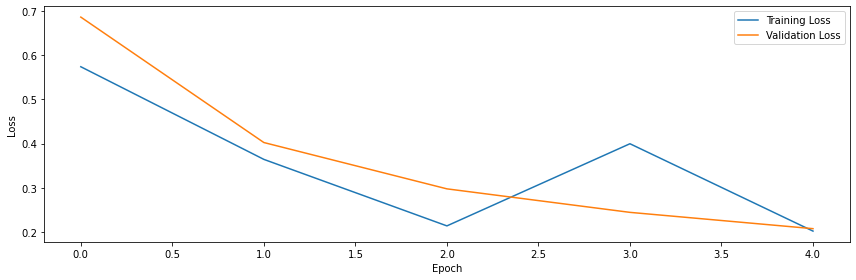

In [16]:
plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.plot(loss_list, label='Training Loss')
plt.plot(val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()


plt.tight_layout()
plt.show()

## Load the saved model for testing and utilization

In [11]:
DiseasePredictor = ResNetClassifer(num_classes).to(device)
if torch.cuda.is_available():
  DiseasePredictor.load_state_dict(torch.load("DiseasedCropClassifier_5epochs_secondIteration.pth"))
else:
  print("WARNING: Model will run extremely slow on cpu. If on colab, go to Runtime->Change Runtime Type->Hardware Accelerator->GPU.")
  DiseasePredictor.load_state_dict(torch.load("/content/siamese_triplet_model_cache.pth", map_location=torch.device('cpu')))
DiseasePredictor.eval()

ResNetClassifer(
  (resnet_model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequentia

### Confirm the Accuracy score on the test dataset and show some examples

In [12]:
test_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

# Initialize variables for accuracy computation
test_accuracy_list = []

with torch.no_grad():
    for batch in tqdm(test_loader):
        x, y = [th.to(device) for th in batch]
        x = DiseasePredictor(x)
        acc = accuracy(x, y)
        test_accuracy_list.append(acc)

# Calculate accuracy for positive and negative pairs separately
average_acc = torch.tensor(test_accuracy_list).mean().item()*100

print(f'Overall Test Accuracy: {average_acc:.6f}%')

100%|██████████| 274/274 [00:51<00:00,  5.30it/s]

Overall Test Accuracy: 96.361768%


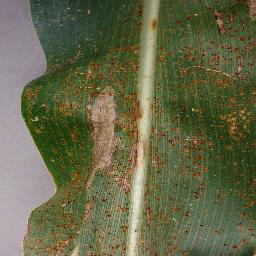

Predicted Label:  Corn_(maize)___Northern_Leaf_Blight
True Label:  Corn_(maize)___Northern_Leaf_Blight


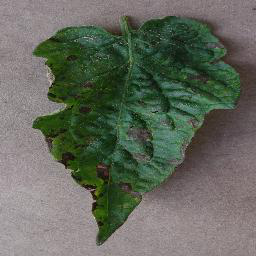

Predicted Label:  Tomato___Early_blight
True Label:  Tomato___Early_blight


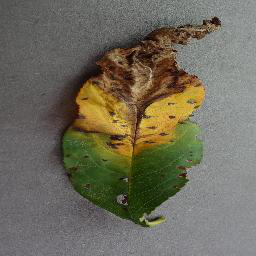

Predicted Label:  Tomato___Bacterial_spot
True Label:  Peach___Bacterial_spot


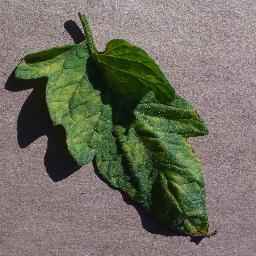

Predicted Label:  Tomato___Leaf_Mold
True Label:  Tomato___Leaf_Mold


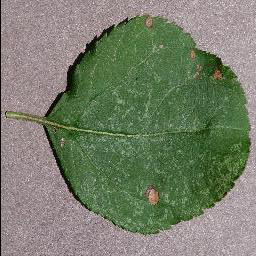

Predicted Label:  Apple___Black_rot
True Label:  Apple___Black_rot


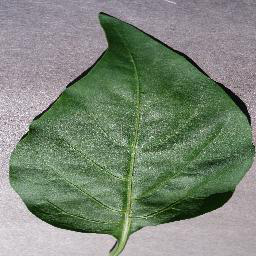

Predicted Label:  Pepper,_bell___healthy
True Label:  Pepper,_bell___healthy


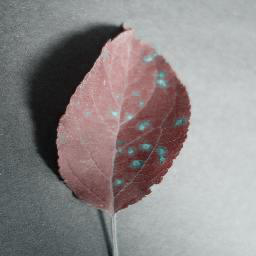

Predicted Label:  Apple___Cedar_apple_rust
True Label:  Apple___Cedar_apple_rust


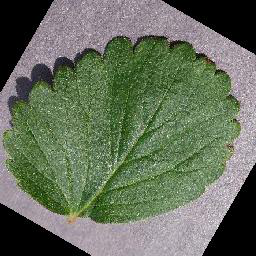

Predicted Label:  Strawberry___healthy
True Label:  Strawberry___healthy


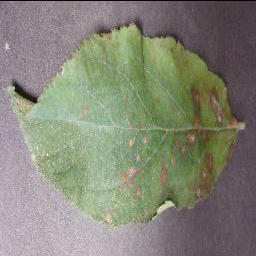

Predicted Label:  Apple___Cedar_apple_rust
True Label:  Apple___Cedar_apple_rust


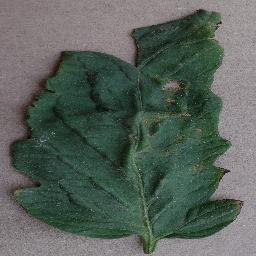

Predicted Label:  Tomato___Bacterial_spot
True Label:  Tomato___Bacterial_spot


In [13]:
import numpy as np
device = 'cpu'
DiseasePredictor.to(device)

for i in np.random.randint(0, len(valid_dataset), 10):
    valid_dataset.displayImage(i)
    img_path, label_idx, label = valid_dataset.getItemVerbose(i)
    prediction = DiseasePredictor(valid_dataset[i][0].to(device).unsqueeze(0))
    _, predicted_classes = prediction.max(1)
    print("Predicted Label: ", valid_dataset.idx_to_class[predicted_classes.item()])
    print("True Label: ", label)